**ImageClassification using convoution neural network from scratch(Numpy code)**

In [ ]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt

(300, 451)

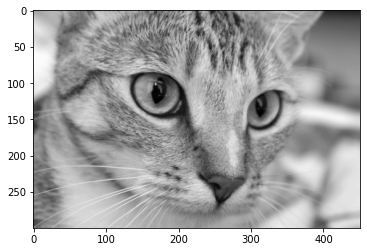

In [ ]:
import skimage.data
# Reading the image
img = skimage.data.chelsea()
# Converting the image into gray.
img = skimage.color.rgb2gray(img)
plt.imshow(img,cmap = 'gray')
img.shape

In [ ]:
num_filters = 2

In [ ]:
def filter(num_filters):
        num_filters = num_filters

        #why divide by 9...Xavier initialization
        filters = np.random.randn(num_filters, 3, 3)/9
        return filters

In [ ]:
filter(num_filters)

array([[[ 0.01080345,  0.1753469 ,  0.04485702],
        [-0.02800927,  0.09131527,  0.05759412],
        [ 0.00649422, -0.0072133 , -0.06732981]],

       [[-0.05182275, -0.16676086, -0.03470344],
        [-0.05595989,  0.0824457 , -0.01881228],
        [ 0.0208855 ,  0.01873853, -0.07873853]]])

In [ ]:
class Conv:

    def __init__(self, num_filters):
        self.num_filters = num_filters

        #why divide by 9...Xavier initialization
        self.filters = np.random.randn(num_filters, 3, 3)/9

    def iterate_regions(self, image):
        #generates all possible 3*3 image regions using valid padding

        h,w = image.shape

        for i in range(h-2):
            for j in range(w-2):
                im_region = image[i:(i+3), j:(j+3)]
                yield im_region, i, j
    def forward(self, input):
        self.last_input = input

        h,w = input.shape

        output = np.zeros((h-2, w-2, self.num_filters))

        for im_regions, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(im_regions * self.filters, axis=(1,2))
        return output

    def backprop(self, d_l_d_out, learn_rate):
        '''
        Performs a backward pass of the conv layer.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a float.
        '''
        d_l_d_filters = np.zeros(self.filters.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_l_d_filters[f] += d_l_d_out[i,j,f] * im_region

        #update filters
        self.filters -= learn_rate * d_l_d_filters

In [ ]:
conn = Conv(18)
out = conn.forward(img)
out.shape

(298, 449, 18)

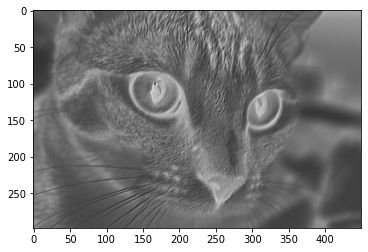

In [ ]:
plt.imshow(out[:,:,17],cmap='gray')
plt.show()

In [ ]:
class MaxPool:
    def iterate_regions(self, image):
        h, w, _ = image.shape

        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i*2):(i*2+2), (j*2):(j*2+2)]
                yield im_region, i, j

    def forward(self, input):

        self.last_input = input

        h, w, num_filters = input.shape
        output = np.zeros((h//2, w//2, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i,j] = np.amax(im_region,axis=(0,1))

        return output

    def backprop(self, d_l_d_out):
        '''
        Performs a backward pass of the maxpool layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        '''
        d_l_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0,1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        #if the pixel was the max value, copy the gradient to it
                        if(im_region[i2,j2,f2] == amax[f2]):
                            d_l_d_input[i*2+i2, j*2+j2 ,f2] = d_l_d_out[i, j, f2]
                            break;
        return d_l_d_input

In [ ]:
conn2 = MaxPool()
out2 = conn2.forward(out)
out2.shape

(149, 224, 18)

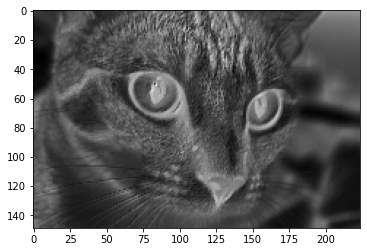

In [ ]:
plt.imshow(out2[:,:,17],cmap='gray')
plt.show()

In [ ]:
class Softmax:
    def __init__(self, input_len, nodes):
        # We divide by input_len to reduce the variance of our initial values
        self.weights = np.random.randn(input_len, nodes)/input_len
        self.biases = np.zeros(nodes)

    def forward(self, input):

        self.last_input_shape = input.shape

        input = input.flatten()
        self.last_input = input

        input_len, nodes = self.weights.shape

        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals

        exp = np.exp(totals)
        return(exp/np.sum(exp, axis=0))

    def backprop(self, d_l_d_out, learn_rate):
        """
        Performs a backward pass of the softmax layer.
        Returns the loss gradient for this layers inputs.
        - d_L_d_out is the loss gradient for this layers outputs.
        """

        #We know only 1 element of d_l_d_out will be nonzero
        for i, gradient in enumerate(d_l_d_out):
            if(gradient == 0):
                continue

            #e^totals
            t_exp = np.exp(self.last_totals)

            #Sum of all e^totals
            S = np.sum(t_exp)

            #gradients of out[i] against totals
            d_out_d_t = -t_exp[i] * t_exp/ (S**2)
            d_out_d_t[i] = t_exp[i] * (S-t_exp[i]) /(S**2)
            # Gradients of totals against weights/biases/input
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

            #Gradients of loss against totals
            d_l_d_t = gradient * d_out_d_t

            #Gradients of loss against weights/biases/input
            d_l_d_w = d_t_d_w[np.newaxis].T @ d_l_d_t[np.newaxis]
            d_l_d_b = d_l_d_t * d_t_d_b
            d_l_d_inputs = d_t_d_inputs @ d_l_d_t

            #update weights/biases
            self.weights -= learn_rate * d_l_d_w
            self.biases -= learn_rate * d_l_d_b
            return d_l_d_inputs.reshape(self.last_input_shape)

In [ ]:
conn3 = Softmax(149*224*18,10)
out3 = conn3.forward(out2)
print(out3)

[0.0999827  0.1000023  0.10001645 0.10002467 0.09997516 0.09998617
 0.09997146 0.1000213  0.10001172 0.10000807]


label: 5


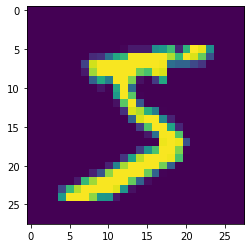

label: 7


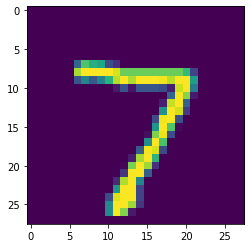

In [ ]:
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
train_images = x_train[:1000]
train_labels = y_train[:1000]
test_images = x_test[:1000]
test_labels = y_test[:1000]

print("label:",train_labels[0])
plt.imshow(train_images[0])
plt.show()
print("label:",test_labels[0])
plt.imshow(test_images[0])
plt.show()

In [ ]:
gradient = np.zeros(10)
gradient[0] = -1/0.234
print(gradient[0])

-4.273504273504273


In [ ]:
conv = Conv(8)                           #28x28x1->26X26X8
pool = MaxPool()                         #26X26X8->13X13X8
softmax = Softmax(13 * 13 * 8, 10)       #13x13x8->10

def forward(image, label):
    # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
    # to work with. This is standard practice.

    out = conv.forward((image/255) - 0.5)
    out = pool.forward(out)
    out = softmax.forward(out)

    #calculate cross-entropy loss and accuracy
    loss = -np.log(out[label])
    acc = 1 if(np.argmax(out) == label) else 0

    return out, loss, acc

def train(im, label, lr=0.005):
    #forward
    out,loss,acc = forward(im, label)

    #calculate initial gradient
    gradient = np.zeros(10)
    gradient[label] = -1/out[label]


    #Backprop
    gradient = softmax.backprop(gradient, lr)
    gradient = pool.backprop(gradient)
    gradient = conv.backprop(gradient, lr)

    return loss, acc


print('MNIST CNN initialized')

for epoch in range(3):
    print('----EPOCH %d ---'%(epoch+1))

    #shuffle the training data
    permutation = np.random.permutation(len(train_images))
    train_images = train_images[permutation]
    train_labels = train_labels[permutation]


    loss = 0
    num_correct = 0
    loss1 = []

    for i, (im, label) in enumerate(zip(train_images, train_labels)):

        #print stats every 100 steps
        if( i %100 == 0):
            print('[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %(i + 1, loss / 100, num_correct))

            loss = 0
            num_correct = 0
        l, acc = train(im, label)
        loss += l
        #l.append(loss1)
        num_correct += acc

MNIST CNN initialized
----EPOCH 1 ---
[Step 1] Past 100 steps: Average Loss 0.000 | Accuracy: 0%
[Step 101] Past 100 steps: Average Loss 2.285 | Accuracy: 17%
[Step 201] Past 100 steps: Average Loss 2.150 | Accuracy: 24%
[Step 301] Past 100 steps: Average Loss 1.957 | Accuracy: 40%
[Step 401] Past 100 steps: Average Loss 1.587 | Accuracy: 52%
[Step 501] Past 100 steps: Average Loss 1.179 | Accuracy: 62%
[Step 601] Past 100 steps: Average Loss 0.734 | Accuracy: 79%
[Step 701] Past 100 steps: Average Loss 1.117 | Accuracy: 60%
[Step 801] Past 100 steps: Average Loss 0.732 | Accuracy: 79%
[Step 901] Past 100 steps: Average Loss 0.643 | Accuracy: 84%
----EPOCH 2 ---
[Step 1] Past 100 steps: Average Loss 0.000 | Accuracy: 0%
[Step 101] Past 100 steps: Average Loss 0.680 | Accuracy: 77%
[Step 201] Past 100 steps: Average Loss 0.583 | Accuracy: 81%
[Step 301] Past 100 steps: Average Loss 0.426 | Accuracy: 89%
[Step 401] Past 100 steps: Average Loss 0.338 | Accuracy: 92%
[Step 501] Past 100 st